## Importing the dependecies

In [4]:
import sys, os, json, re
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text / NLP
from textblob import TextBlob          # optional comparison
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Feature extraction / simple modeling (for TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# set plotting aesthetics
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
print("successfully brought the dependencies")

successfully brought the dependencies


## Data loading

In [8]:
from pathlib import Path
import pandas as pd

# Resolve repository root (handles running from notebooks/ or repo root)
repo_root = Path().resolve()
if (repo_root / "scripts").exists() is False and (repo_root.parent / "scripts").exists():
    repo_root = repo_root.parent

# Build absolute raw file path
raw_path = repo_root / "data" / "raw" / "reviews_raw.csv"
print("Repo root:", repo_root)
print("Raw path resolved to:", raw_path)

# Fallback: search for any reviews CSV if canonical file missing
if not raw_path.exists():
    candidates = list(repo_root.rglob("*reviews*.csv"))
    if candidates:
        raw_path = candidates[0]
        print("Canonical file not found — using first candidate:", raw_path)
    else:
        raise FileNotFoundError(f"No reviews CSV found under {repo_root}; run scraper or move file to data/raw/reviews_raw.csv")

df = pd.read_csv(raw_path)
df.columns = [c.strip() for c in df.columns]
print("Loaded rows:", len(df))
df.head(9)


Repo root: /home/avicci/Analytics_for_fintech_apps
Raw path resolved to: /home/avicci/Analytics_for_fintech_apps/data/raw/reviews_raw.csv
Loaded rows: 1350


,review_id,review_text,rating,review_date,bank_code,bank_name,source
0,68d8daea-db47-4e23-a692-755173dea983,maaliif daddafee install gaafata,3,2025-11-28 13:36:32,CBE,Commercial Bank of Ethiopia,Google Play
1,ee0dbb0e-4eb0-47b5-9874-c37877493f99,good app,5,2025-11-28 11:33:17,CBE,Commercial Bank of Ethiopia,Google Play
2,5112423d-e618-44ba-ba49-62677cb76cd6,This application is very important and advanta...,5,2025-11-27 23:08:20,CBE,Commercial Bank of Ethiopia,Google Play
3,bcb34681-1dd4-4781-b400-4393bb10b1d9,why didn't work this app?,1,2025-11-27 22:40:35,CBE,Commercial Bank of Ethiopia,Google Play
4,c69f051a-00f8-4144-8423-b7ebcd328d2d,The app makes our life easier. Thank you CBE!,5,2025-11-27 18:00:06,CBE,Commercial Bank of Ethiopia,Google Play
5,d2995fb9-63c6-4bfc-8d3c-93a0ee9dba8f,this app very bad 👎,1,2025-11-27 16:28:10,CBE,Commercial Bank of Ethiopia,Google Play
6,f8002d06-b5c5-4ed1-9d51-a9a379304cf8,the most advanced app. but how to stay safe?,5,2025-11-27 10:03:41,CBE,Commercial Bank of Ethiopia,Google Play
7,81000db5-aa51-467e-826c-fc96160e96a8,Good application,4,2025-11-27 08:59:12,CBE,Commercial Bank of Ethiopia,Google Play
8,3d88a334-958c-4717-9f97-c5d46359e054,It is nice app,5,2025-11-26 12:03:18,CBE,Commercial Bank of Ethiopia,Google Play


## Map star ratings → sentiment labels (for ML)

In [10]:
# ...existing code...
def rating_to_label(r):
    if r <= 2:
        return "negative"
    elif r == 3:
        return "neutral"
    else:
        return "positive"

# safer: keep rating-based label in a separate column
# df["rating_label"] = df["rating"].apply(rating_to_label)

# if you really want to overwrite 'sentiment_label', uncomment:
df["sentiment_label"] = df["rating"].apply(rating_to_label)

df.head()
# ...existing code...

,review_id,review_text,rating,review_date,bank_code,bank_name,source,sentiment_label
0,68d8daea-db47-4e23-a692-755173dea983,maaliif daddafee install gaafata,3,2025-11-28 13:36:32,CBE,Commercial Bank of Ethiopia,Google Play,neutral
1,ee0dbb0e-4eb0-47b5-9874-c37877493f99,good app,5,2025-11-28 11:33:17,CBE,Commercial Bank of Ethiopia,Google Play,positive
2,5112423d-e618-44ba-ba49-62677cb76cd6,This application is very important and advanta...,5,2025-11-27 23:08:20,CBE,Commercial Bank of Ethiopia,Google Play,positive
3,bcb34681-1dd4-4781-b400-4393bb10b1d9,why didn't work this app?,1,2025-11-27 22:40:35,CBE,Commercial Bank of Ethiopia,Google Play,negative
4,c69f051a-00f8-4144-8423-b7ebcd328d2d,The app makes our life easier. Thank you CBE!,5,2025-11-27 18:00:06,CBE,Commercial Bank of Ethiopia,Google Play,positive


1. Frequency based vs TF-IDF analysis

Basic text cleaning

In [ ]:


df["clean_text"] = df["review_text"].str.lower()
df[["review_text", "clean_text"]]


,review_text,clean_text
0,maaliif daddafee install gaafata,maaliif daddafee install gaafata
1,good app,good app
2,This application is very important and advanta...,this application is very important and advanta...
3,why didn't work this app?,why didn't work this app?
4,The app makes our life easier. Thank you CBE!,the app makes our life easier. thank you cbe!
...,...,...
1345,Convenient!,convenient!
1346,It is an amazing application that meets the ne...,it is an amazing application that meets the ne...
1347,Effecting payment via the app has created conv...,effecting payment via the app has created conv...
1348,the best Supper App ever,the best supper app ever


Frequnecy-based representation

In [ ]:
# Frequency-based word counts using CountVectorizer

count_vec = CountVectorizer(stop_words="english")
X_counts = count_vec.fit_transform(df["clean_text"])

# Sum counts for each word across all documents
word_counts = np.asarray(X_counts.sum(axis=0)).flatten()
vocab = np.array(count_vec.get_feature_names_out())

freq_df = pd.DataFrame({"word": vocab, "count": word_counts})
freq_df = freq_df.sort_values("count", ascending=False)
freq_df.head(10)


,word,count
125,app,510
745,good,232
188,bank,137
227,best,112
193,banking,90
1109,nice,72
1684,use,68
1062,mobile,59
1769,work,55
955,like,53


visualize top frequent words

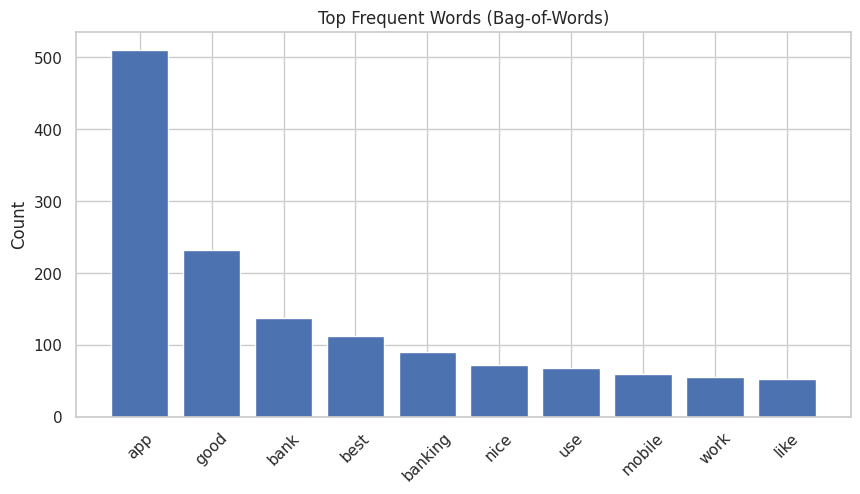

In [ ]:
# Plot top frequent words (Frequency-Based)
top_n = 10
top_freq = freq_df.head(top_n)

plt.bar(top_freq["word"], top_freq["count"])
plt.xticks(rotation=45)
plt.title("Top Frequent Words (Bag-of-Words)")
plt.ylabel("Count")
plt.show()


TF-IDF representation

In [ ]:
# TF-IDF representation

tfidf_vec = TfidfVectorizer(stop_words="english")
X_tfidf = tfidf_vec.fit_transform(df["clean_text"])

# Get average TF-IDF score per word across documents
tfidf_means = np.asarray(X_tfidf.mean(axis=0)).flatten()
vocab_tfidf = np.array(tfidf_vec.get_feature_names_out())

tfidf_df = pd.DataFrame({"word": vocab_tfidf, "tfidf": tfidf_means})
tfidf_df = tfidf_df.sort_values("tfidf", ascending=False)
tfidf_df.head(10)


,word,tfidf
745,good,0.124485
125,app,0.075635
227,best,0.050033
1109,nice,0.039712
188,bank,0.022728
755,great,0.017417
1777,wow,0.016592
594,excellent,0.016010
193,banking,0.015319
955,like,0.015198


Compare TF-IDF vs raw frequnecy

In [16]:
# Cell 10: Compare top words by frequency and by TF-IDF

print("Top 10 by raw frequency:")
display(freq_df.head(10))

print("\nTop 10 by TF-IDF (words more unique / informative):")
display(tfidf_df.head(10))


Top 10 by raw frequency:


,word,count
125,app,510
745,good,232
188,bank,137
227,best,112
193,banking,90
1109,nice,72
1684,use,68
1062,mobile,59
1769,work,55
955,like,53



Top 10 by TF-IDF (words more unique / informative):


,word,tfidf
745,good,0.124485
125,app,0.075635
227,best,0.050033
1109,nice,0.039712
188,bank,0.022728
755,great,0.017417
1777,wow,0.016592
594,excellent,0.016010
193,banking,0.015319
955,like,0.015198


Topic modeling

In [17]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize text (very simple split for demo)
df["tokens"] = df["clean_text"].str.split()

# Create dictionary and corpus for LDA
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]


In [18]:
import nltk
from nltk.corpus import stopwords

# Download stopwords (only first time)
nltk.download('stopwords')

stop_words = set(stopwords.words("english"))
# Remove stopwords from your tokenized text
df["tokens_nostop"] = df["tokens"].apply(
    lambda words: [w for w in words if w not in stop_words]
)

df[["clean_text", "tokens", "tokens_nostop"]].head()



[nltk_data] Downloading package stopwords to /home/avicci/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,clean_text,tokens,tokens_nostop
0,maaliif daddafee install gaafata,"[maaliif, daddafee, install, gaafata]","[maaliif, daddafee, install, gaafata]"
1,good app,"[good, app]","[good, app]"
2,this application is very important and advanta...,"[this, application, is, very, important, and, ...","[application, important, advantage, transfer, ..."
3,why didn't work this app?,"[why, didn't, work, this, app?]","[work, app?]"
4,the app makes our life easier. thank you cbe!,"[the, app, makes, our, life, easier., thank, y...","[app, makes, life, easier., thank, cbe!]"


In [20]:
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
# Use stopword-cleaned tokens
dictionary = Dictionary(df["tokens_nostop"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens_nostop"]]


lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=2,
    passes=10,
    random_state=42
)


In [21]:
topics = lda_model.show_topics(num_topics=2, num_words=10, formatted=False)

for i, topic in topics:
    print(f"\n--- Topic {i+1} ---")
    for word, weight in topic:
        print(f"{word:15s}  weight={weight:.4f}")



--- Topic 1 ---
app              weight=0.0535
good             weight=0.0330
best             weight=0.0170
bank             weight=0.0124
nice             weight=0.0104
banking          weight=0.0103
mobile           weight=0.0076
dashen           weight=0.0074
great            weight=0.0066
use              weight=0.0065

--- Topic 2 ---
app              weight=0.0141
like             weight=0.0071
bank             weight=0.0065
excellent        weight=0.0060
wow              weight=0.0055
working          weight=0.0052
even             weight=0.0050
apps             weight=0.0049
ok               weight=0.0047
worst            weight=0.0045


Noun extraction

In [22]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    doc = nlp(text)
    return [token.text for token in doc if token.pos_ == "NOUN"]

df["nouns"] = df["review_text"].apply(extract_nouns)
df[["review_text", "nouns"]]


,review_text,nouns
0,maaliif daddafee install gaafata,"[daddafee, install, gaafata]"
1,good app,[app]
2,This application is very important and advanta...,"[application, transfer, money, finance, coutry..."
3,why didn't work this app?,[app]
4,The app makes our life easier. Thank you CBE!,"[app, life]"
...,...,...
1345,Convenient!,[]
1346,It is an amazing application that meets the ne...,"[application, needs, customers]"
1347,Effecting payment via the app has created conv...,"[Effecting, payment, app, convenience, recipie..."
1348,the best Supper App ever,[]


# 2 – Lexicon-Based Sentiment (TextBlob & VADER)

TextBlob sentiment

In [ ]:
# Lexicon-based sentiment with TextBlob
# Polarity in [-1, 1], subjectivity in [0, 1]
# Get polarity and subjectivity
df["tb_polarity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["tb_subjectivity"] = df["review_text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Convert polarity → sentiment label
def polarity_to_label(p):
    if p > 0.1:
        return "positive"
    elif p < -0.1:
        return "negative"
    else:
        return "neutral"

df["tb_sentiment"] = df["tb_polarity"].apply(polarity_to_label)

# Show output
df[["review_text", "rating", "tb_polarity", "tb_subjectivity", "tb_sentiment"]]


,review_text,rating,tb_polarity,tb_subjectivity,tb_sentiment
0,maaliif daddafee install gaafata,3,0.000000,0.000000,neutral
1,good app,5,0.700000,0.600000,positive
2,This application is very important and advanta...,5,0.520000,1.000000,positive
3,why didn't work this app?,1,0.000000,0.000000,neutral
4,The app makes our life easier. Thank you CBE!,5,0.000000,0.000000,neutral
...,...,...,...,...,...
1345,Convenient!,5,0.000000,0.000000,neutral
1346,It is an amazing application that meets the ne...,5,0.600000,0.900000,positive
1347,Effecting payment via the app has created conv...,5,0.541667,0.833333,positive
1348,the best Supper App ever,5,1.000000,0.300000,positive


In [25]:
# Download VADER lexicon for sentiment analysis (only first time)
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/avicci/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [26]:
def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
df["vader_compound"] = df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Show output
df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]


,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,maaliif daddafee install gaafata,3,0.000000,0.0000,neutral
1,good app,5,0.700000,0.4404,positive
2,This application is very important and advanta...,5,0.520000,0.5198,positive
3,why didn't work this app?,1,0.000000,0.0000,neutral
4,The app makes our life easier. Thank you CBE!,5,0.000000,0.6800,positive
...,...,...,...,...,...
1345,Convenient!,5,0.000000,0.0000,neutral
1346,It is an amazing application that meets the ne...,5,0.600000,0.5859,positive
1347,Effecting payment via the app has created conv...,5,0.541667,0.5707,positive
1348,the best Supper App ever,5,1.000000,0.6369,positive


VADER sentiment

In [27]:
# Lexicon-based sentiment with VADER
# VADER is optimized for reviews, slang, emojis, and short texts

def vader_compound(text):
    return sia.polarity_scores(text)["compound"]

# VADER compound score
df["vader_compound"] = df["review_text"].apply(vader_compound)

# Convert compound score → sentiment label
# Standard VADER rule:
# compound >= 0.05 → positive
# compound <= -0.05 → negative
# otherwise → neutral

def vader_label(c):
    if c >= 0.05:
        return "positive"
    elif c <= -0.05:
        return "negative"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_compound"].apply(vader_label)

# Show output
df[["review_text", "rating", "tb_polarity", "vader_compound", "vader_sentiment"]]


,review_text,rating,tb_polarity,vader_compound,vader_sentiment
0,maaliif daddafee install gaafata,3,0.000000,0.0000,neutral
1,good app,5,0.700000,0.4404,positive
2,This application is very important and advanta...,5,0.520000,0.5198,positive
3,why didn't work this app?,1,0.000000,0.0000,neutral
4,The app makes our life easier. Thank you CBE!,5,0.000000,0.6800,positive
...,...,...,...,...,...
1345,Convenient!,5,0.000000,0.0000,neutral
1346,It is an amazing application that meets the ne...,5,0.600000,0.5859,positive
1347,Effecting payment via the app has created conv...,5,0.541667,0.5707,positive
1348,the best Supper App ever,5,1.000000,0.6369,positive


## Viaualization of lexicon scores vs rating

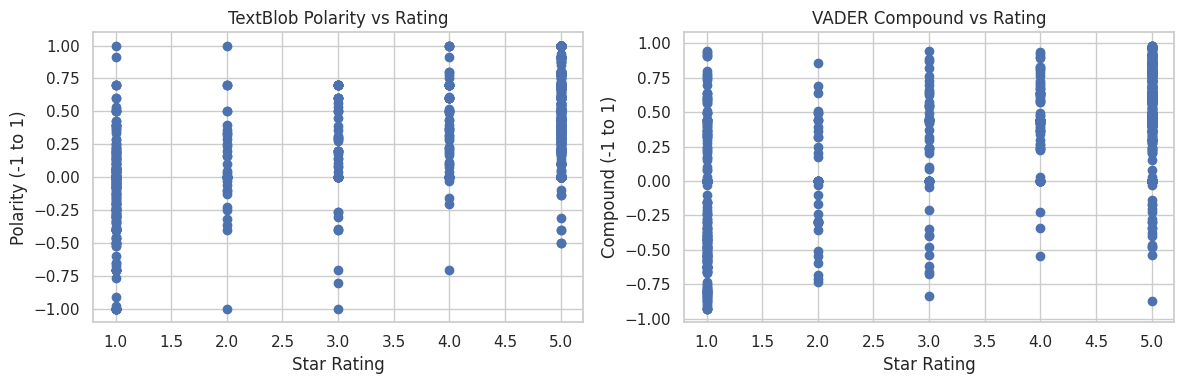

In [28]:
# See how lexicon scores correlate with star rating

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(df["rating"], df["tb_polarity"])
axes[0].set_title("TextBlob Polarity vs Rating")
axes[0].set_xlabel("Star Rating")
axes[0].set_ylabel("Polarity (-1 to 1)")

axes[1].scatter(df["rating"], df["vader_compound"])
axes[1].set_title("VADER Compound vs Rating")
axes[1].set_xlabel("Star Rating")
axes[1].set_ylabel("Compound (-1 to 1)")

plt.tight_layout()
plt.show()
